In [1]:
import os, glob
import shutil
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm


## 1. Models

- CNN_80x80_2Conv_2Pool_2FC: input 80x80 x3channels; 2 conv, 2 pool, 2 fully connected; output 2 classes
- other to add and try...

In [16]:
class CNN_80x160_2Conv_2Pool_2FC(nn.Module):
    def __init__(self):
        super(CNN_80x160_2Conv_2Pool_2FC, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 20 * 40, 256)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(256, 12)  # Two output classes: empty and no_empty

        self.dropoutC = nn.Dropout(0.05)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        #x = self.dropoutC(x)
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        #probabilities = F.softmax(x, dim=1)
        return x

In [44]:
class ResNet18(nn.Module):
    """ResNet18 model.
    """

    def __init__(self):
        super().__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        n = self.model.fc.in_features
        self.model.fc = nn.Linear(n, 12)

    def forward(self, x):
        return self.model(x)

In [4]:
class ResNet50(nn.Module):
    """ResNet50 model.
    """

    def __init__(self):
        super().__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        n = self.model.fc.in_features
        self.model.fc = nn.Linear(n, 12)

    def forward(self, x):
        return self.model(x)

## 2. Prepare and Load dataset

In [5]:
# Change dir in /kaggle
os.chdir('/kaggle')
print("current dir changed to:", os.getcwd())
print(f"listdir: {os.listdir()}")

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

current dir changed to: /kaggle
listdir: ['lib', 'input', 'working']
Device: cuda


In [6]:
# Funzione per riempire le liste
def fill_lists(setname, data_list, labels_list):
    print(f"Processing {setname} data")
    
    for filename in tqdm(os.listdir(f'./input/pieces/{setname}_pieces/'), desc=f"{setname}", unit="File"):
        if filename.endswith('.png'):
            txt_filename = os.path.join(f'./input/pieces/{setname}_pieces/', f"{os.path.splitext(filename)[0]}.txt")
            img_path = os.path.join(f'./input/pieces/{setname}_pieces/', filename)
            
            with open(txt_filename, 'r') as file:
                piece_name = file.read()

                data_list.append(img_path)
                labels_list.append(piece_name)

In [7]:
train_data = []
train_labels = []

validation_data = []
validation_labels = []

test_data = []
test_labels = []

class_names = ['b_Pawn','b_Bishop','b_Knight','b_Rook','b_Queen','b_King', 'w_King','w_Queen','w_Rook','w_Knight','w_Bishop','w_Pawn']

# Riempimento delle liste per training, validation e test
fill_lists('training', train_data, train_labels)
fill_lists('validation', validation_data, validation_labels)
fill_lists('test', test_data, test_labels)

# Shuffle dei dati
train_data, train_labels = shuffle(train_data, train_labels, random_state=4)
validation_data, validation_labels = shuffle(validation_data, validation_labels, random_state=4)
test_data, test_labels = shuffle(test_data, test_labels, random_state=4)

Processing training data


training: 100%|██████████| 165734/165734 [04:39<00:00, 593.03File/s] 


Processing validation data


validation: 100%|██████████| 5752/5752 [00:23<00:00, 246.65File/s]


Processing test data


test: 100%|██████████| 13020/13020 [00:51<00:00, 251.77File/s]


In [8]:
num_training = len(train_data)
num_validation = len(validation_data)
num_test = len(test_data)

# Conteggio delle immagini per ogni set
print(f"training: {num_training}")
print(f"validation: {len(validation_data)}")
print(f"test: {len(test_data)}")

print("Training")
for class_name in class_names:
    num_class = train_labels.count(class_name)
    print(f"\t{class_name}: {num_class} ({num_class/num_training:.1%})")

print("Validation")
for class_name in class_names:
    num_class = validation_labels.count(class_name)
    print(f"\t{class_name}: {num_class} ({num_class/num_validation:.1%})")
    
print("Test")
for class_name in class_names:
    num_class = test_labels.count(class_name)
    print(f"\t{class_name}: {num_class} ({num_class/num_test:.1%})")

training: 82867
validation: 2876
test: 6510
Training
	b_Pawn: 21494 (25.9%)
	b_Bishop: 4116 (5.0%)
	b_Knight: 3744 (4.5%)
	b_Rook: 5655 (6.8%)
	b_Queen: 2443 (2.9%)
	b_King: 3988 (4.8%)
	w_King: 3988 (4.8%)
	w_Queen: 2458 (3.0%)
	w_Rook: 5648 (6.8%)
	w_Knight: 3700 (4.5%)
	w_Bishop: 4133 (5.0%)
	w_Pawn: 21500 (25.9%)
Validation
	b_Pawn: 740 (25.7%)
	b_Bishop: 155 (5.4%)
	b_Knight: 130 (4.5%)
	b_Rook: 196 (6.8%)
	b_Queen: 80 (2.8%)
	b_King: 134 (4.7%)
	w_King: 134 (4.7%)
	w_Queen: 81 (2.8%)
	w_Rook: 198 (6.9%)
	w_Knight: 138 (4.8%)
	w_Bishop: 146 (5.1%)
	w_Pawn: 744 (25.9%)
Test
	b_Pawn: 1686 (25.9%)
	b_Bishop: 326 (5.0%)
	b_Knight: 296 (4.5%)
	b_Rook: 449 (6.9%)
	b_Queen: 191 (2.9%)
	b_King: 310 (4.8%)
	w_King: 310 (4.8%)
	w_Queen: 194 (3.0%)
	w_Rook: 451 (6.9%)
	w_Knight: 289 (4.4%)
	w_Bishop: 326 (5.0%)
	w_Pawn: 1682 (25.8%)


In [9]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = [class_names.index(label) for label in labels]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]

        # Carica l'immagine da file
        img = Image.open(img_path)
        #img = transforms.ToTensor()(img).to(device)
        
        # Applica le trasformazioni se specificate
        if self.transform:
            img = self.transform(img)

        return img, label

In [18]:
transformers = {}

# conv80x80_2_2_2
transformers["CNN_80x160_2Conv_2Pool_2FC"] = transforms.Compose([
    transforms.Resize((80, 160)),
    transforms.ToTensor()
])

# resnet
transformers["ResNet"] = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# 80x160
transformers["80x160"] = transforms.Compose([
    transforms.Resize((80, 160)),
    transforms.ToTensor()
])

In [45]:
model = ResNet18()
modelname = '80x160'

train_ds = CustomDataset(train_data, train_labels, transform=transformers[modelname])
validation_ds = CustomDataset(validation_data, validation_labels, transform=transformers[modelname])
test_ds = CustomDataset(test_data, test_labels, transform=transformers[modelname])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s] 


In [46]:
# Crea i dataloader
batch_size = 32

if device.type == 'cpu':
    train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(validation_ds, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
else:
    train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    validation_dataloader = DataLoader(validation_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

## 3. Train Model

In [47]:
# Inizializza la rete
#model = ResNet()
model.to(device)

# Learning functions
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, threshold=0.02, threshold_mode='rel', factor=0.5, verbose=True)

# Training params
epochs = 0
num_epochs = 150
# Early stopping
best_valid_loss = float('inf')
early_stopping_patience = 7  # Sostituisci con il tuo valore desiderato
early_stopping_counter = 0

# Liste per salvare i valori di loss e checkpoint
train_losses = []
validation_losses = []
model_saves_path = './working/'

In [48]:
 # Training della rete
for epoch in range(epochs, num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.to(device))

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # Calcola la media della loss sul set di training
    train_loss = running_loss / len(train_dataloader)
    
    # Valutazione sul set di validazione
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            valid_loss += criterion(outputs, labels.to(device))

    # Calcola la media della loss sul set di validazione
    valid_loss /= len(validation_dataloader)

     # Adjust learning rate using the scheduler
    scheduler.step(valid_loss)

    # Aggiorna le liste di loss
    train_losses.append(loss.item())
    validation_losses.append(valid_loss.item())

    # Controlla se la loss sul set di validazione è migliorata
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        early_stopping_counter = 0
    else:
        # Incrementa il contatore di early stopping
        early_stopping_counter += 1

    print(f'Train Loss: {loss.item():.4f}, Valid Loss: {valid_loss.item():.4f}, Patience count: {early_stopping_counter}')

    # Se la loss non migliora per un numero specifico di epoche, interrompi il training
    if early_stopping_counter >= early_stopping_patience:
        print(f'Early stopping after {early_stopping_counter + 1} epochs without improvement.')
        break

    if not epoch % 2:
      os.makedirs(model_saves_path, exist_ok=True)
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': loss,
          'valid_loss': valid_loss,
          'early_stopping_counter': early_stopping_counter,
          'train_losses': train_losses,
          'validation_losses': validation_losses,
          }, f"{model_saves_path}{model._get_name()}_b{batch_size}_ep{epoch}.tar")
      print(f"Salvato checkpoint {model_saves_path}{model._get_name()}_b{batch_size}_ep{epoch}.tar")

Epoch 1/150: 100%|██████████| 2590/2590 [01:15<00:00, 34.52batch/s]


Train Loss: 0.0018, Valid Loss: 0.0452, Patience count: 0
Salvato checkpoint ./working/ResNet18_b32_ep0.tar


Epoch 2/150: 100%|██████████| 2590/2590 [01:06<00:00, 38.70batch/s]


Train Loss: 0.0052, Valid Loss: 0.0290, Patience count: 0


Epoch 3/150: 100%|██████████| 2590/2590 [01:07<00:00, 38.43batch/s]


Train Loss: 0.0030, Valid Loss: 0.0622, Patience count: 1
Salvato checkpoint ./working/ResNet18_b32_ep2.tar


Epoch 4/150: 100%|██████████| 2590/2590 [01:07<00:00, 38.42batch/s]


Train Loss: 0.0042, Valid Loss: 0.0489, Patience count: 2


Epoch 5/150: 100%|██████████| 2590/2590 [01:07<00:00, 38.30batch/s]


Train Loss: 0.0000, Valid Loss: 0.0179, Patience count: 0
Salvato checkpoint ./working/ResNet18_b32_ep4.tar


Epoch 6/150: 100%|██████████| 2590/2590 [01:08<00:00, 37.77batch/s]


Train Loss: 0.0000, Valid Loss: 0.0237, Patience count: 1


Epoch 7/150: 100%|██████████| 2590/2590 [01:08<00:00, 37.88batch/s]


Train Loss: 0.0015, Valid Loss: 0.0220, Patience count: 2
Salvato checkpoint ./working/ResNet18_b32_ep6.tar


Epoch 8/150: 100%|██████████| 2590/2590 [01:08<00:00, 37.92batch/s]


Train Loss: 0.0005, Valid Loss: 0.0042, Patience count: 0


Epoch 9/150: 100%|██████████| 2590/2590 [01:08<00:00, 37.91batch/s]


Train Loss: 0.0000, Valid Loss: 0.0079, Patience count: 1
Salvato checkpoint ./working/ResNet18_b32_ep8.tar


Epoch 10/150: 100%|██████████| 2590/2590 [01:08<00:00, 37.94batch/s]


Train Loss: 0.0000, Valid Loss: 0.0118, Patience count: 2


Epoch 11/150: 100%|██████████| 2590/2590 [01:08<00:00, 38.06batch/s]


Train Loss: 0.0009, Valid Loss: 0.0125, Patience count: 3
Salvato checkpoint ./working/ResNet18_b32_ep10.tar


Epoch 12/150: 100%|██████████| 2590/2590 [01:07<00:00, 38.12batch/s]


Epoch 00012: reducing learning rate of group 0 to 1.0000e-03.
Train Loss: 0.0090, Valid Loss: 0.0120, Patience count: 4


Epoch 13/150: 100%|██████████| 2590/2590 [01:08<00:00, 38.03batch/s]


Train Loss: 0.0000, Valid Loss: 0.0074, Patience count: 5
Salvato checkpoint ./working/ResNet18_b32_ep12.tar


Epoch 14/150: 100%|██████████| 2590/2590 [01:08<00:00, 37.79batch/s]


Train Loss: 0.0000, Valid Loss: 0.0054, Patience count: 6


Epoch 15/150: 100%|██████████| 2590/2590 [01:08<00:00, 37.88batch/s]


Train Loss: 0.0000, Valid Loss: 0.0055, Patience count: 7
Early stopping after 8 epochs without improvement.


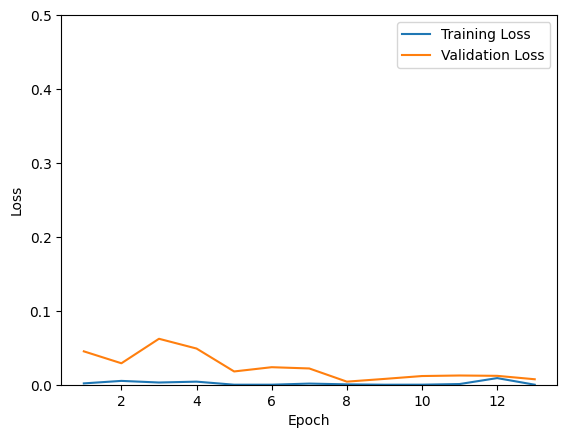

In [64]:
import matplotlib.pyplot as plt


# Plot dei valori di training loss e validation loss
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.5)
plt.legend()
plt.show()

## 4. Test Model
Test the model on test data and evaluate accuracy

### Se si vuole testare un modello in particolare messo in input, diverso da quello precedente

In [52]:
if True:
    modelpath = "/kaggle/working/ResNet18_b32_ep12.tar"
    
    # inizializzare il modello e optimizer giusti, per poter caricare gli state dict giusti
    model = ResNet18()
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.002)
    if os.path.exists(modelpath):
        checkpoint = torch.load(modelpath, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epochs = checkpoint['epoch']
        loss = checkpoint['loss']
        valid_loss = checkpoint['valid_loss']
        early_stopping_counter = checkpoint['early_stopping_counter']
        train_losses = checkpoint['train_losses']
        validation_losses = checkpoint['validation_losses']
    model.to(device)

In [53]:
# Test della rete
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader, desc=f"Testing", unit="batch"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += len(labels)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Testing: 100%|██████████| 204/204 [00:05<00:00, 34.24batch/s]

Test Accuracy: 99.75%


### Test completo
Tieni tutte le predictions e true labels dei vari batch, cosi' da avere confusion matrix e altre metriche

Testing: 100%|██████████| 204/204 [00:04<00:00, 41.75batch/s]


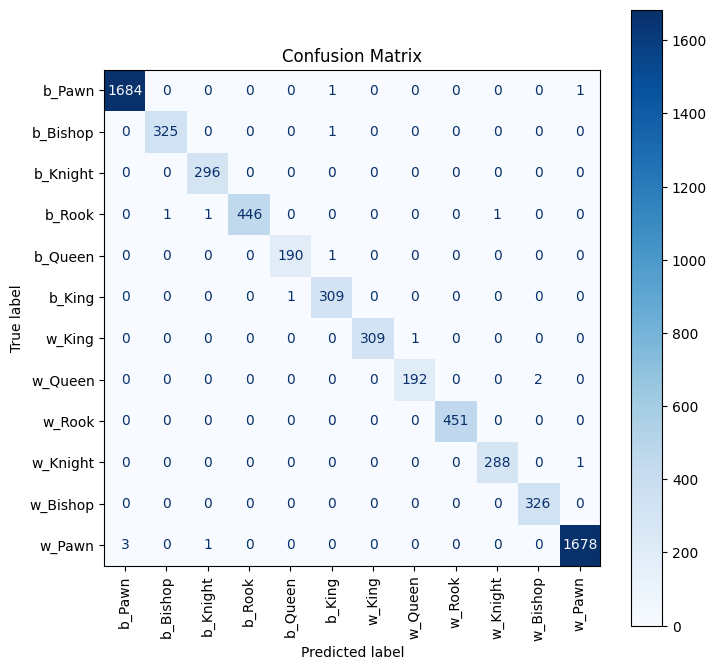

Accuracy: 0.9975
F1 Score: 0.9966
Precision: 0.9965
Recall: 0.9968


In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt


model.to(device)
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader, desc="Testing", unit="batch"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calcolo della matrice di confusione
cm = confusion_matrix(all_labels, all_predictions, labels=[i for i in range(len(class_names))])
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)

# Plot della matrice di confusione
fig, ax = plt.subplots(figsize=(8, 8))
cmd.plot(ax=ax, cmap="Blues")
plt.xticks(rotation=90)
plt.title("Confusion Matrix")
plt.show()

# Calcola l'accuracy
accuracy = accuracy_score(all_labels, all_predictions)

# Calcola l'F1 score
f1 = f1_score(all_labels, all_predictions, average='macro')

# Calcola la precision
precision = precision_score(all_labels, all_predictions, average='macro')

# Calcola la recall
recall = recall_score(all_labels, all_predictions, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

## 5. Save Model

In [57]:
additional_info = "_80x160"

In [58]:
from datetime import datetime

def get_unique_filename(base_filename):
    filename, file_extension = os.path.splitext(base_filename)
    index = 0
    new_filename = base_filename
    while os.path.exists(new_filename):
        new_filename = f"{filename}_{str(index).zfill(4)}{file_extension}"
        index += 1
    return new_filename, index

model_saves_path = './working/'
current_datetime = datetime.now().strftime("%d/%m/%Y %H:%M")

filename_base = f"{model_saves_path}{model._get_name()}{additional_info}"
filename_model, i = get_unique_filename(f"{filename_base}.pth")
filename_model_info, j = get_unique_filename(f"{filename_base}.txt")
if i != j:
  raise Exception(f'Unwanted error on naming files: \n\t{filename_model}\n\t{filename_model_info}')
filename_model


'./working/ResNet18_80x160.pth'

In [59]:
from datetime import datetime

def get_unique_filename(base_filename):
    filename, file_extension = os.path.splitext(base_filename)
    index = 0
    new_filename = base_filename
    while os.path.exists(new_filename):
        new_filename = f"{filename}_{str(index).zfill(4)}{file_extension}"
        index += 1
    return new_filename, index

model_saves_path = './working/'
current_datetime = datetime.now().strftime("%d/%m/%Y %H:%M")

filename_base = f"{model_saves_path}{model._get_name()}{additional_info}"
filename_model, i = get_unique_filename(f"{filename_base}.pth")
filename_model_info, j = get_unique_filename(f"{filename_base}.txt")
if i != j:
  raise Exception(f'Unwanted error on naming files: \n\t{filename_model}\n\t{filename_model_info}')

torch.save(model, f"{filename_model}")
print(f"Saved {filename_model}")

with open(f"{filename_model_info}", "w") as file:
  file.write(f"Acc: {accuracy * 100:.2f}%\n")
  file.write(f"Date: {current_datetime}\n")

  file.write("\nOn data:\n")
  file.write(f"\tTrain: {len(train_data)}\n")
  file.write(f"\tValidation: {len(validation_data)}\n")
  file.write(f"\tTest: {len(test_data)}\n")
print(f"Saved {filename_model_info}")

Saved ./working/ResNet18_80x160.pth
Saved ./working/ResNet18_80x160.txt
